Weighted Recall (R): 0.8867
Weighted Precision (P): 0.9568
F_beta^w score: 0.9397


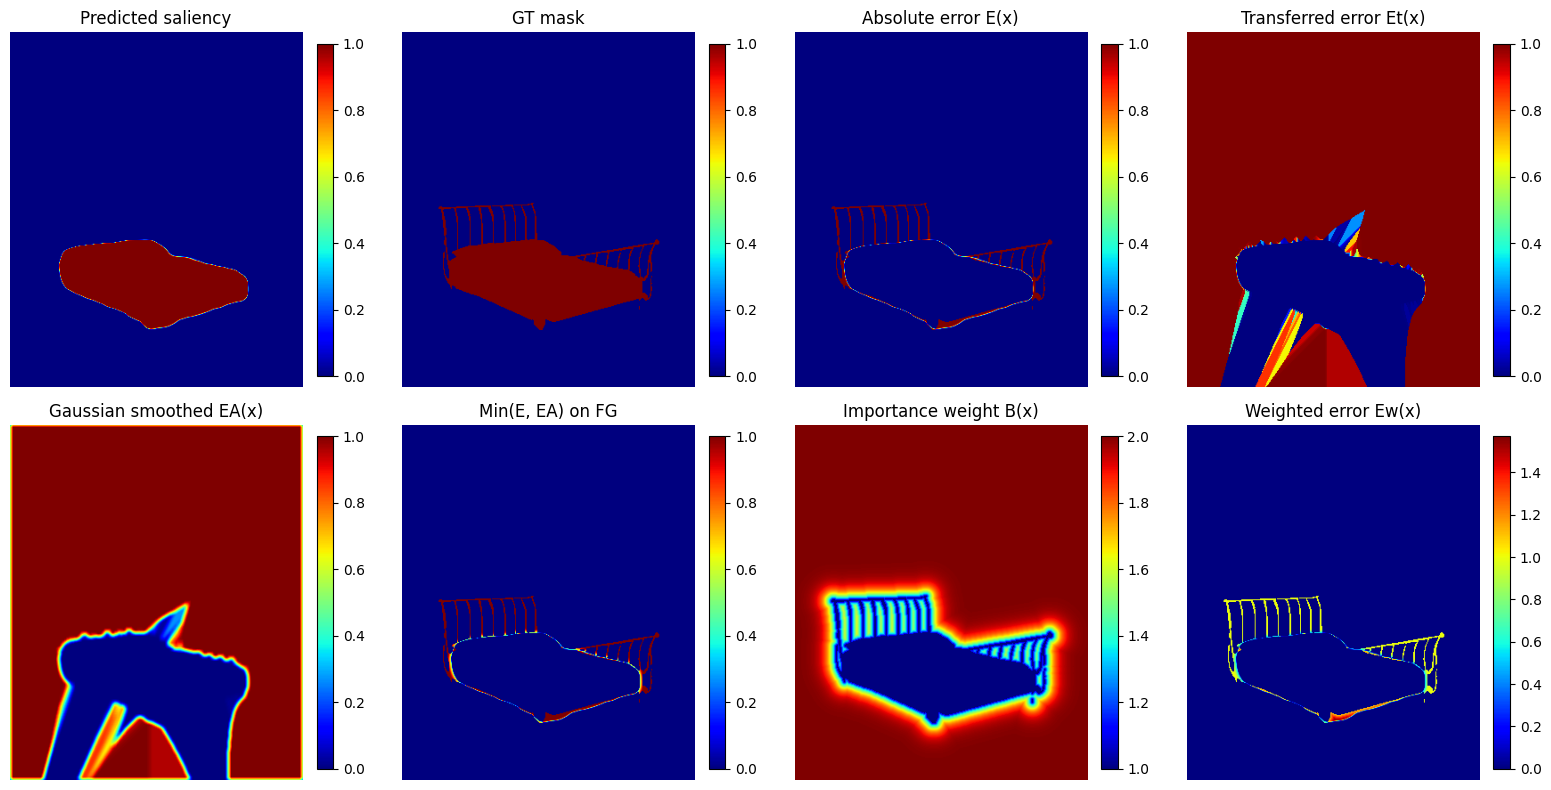

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt, gaussian_filter
from PIL import Image

# ====== CONFIG ======
gt_path = "./gt/Dataset_1/im005.png"   # path to predicted saliency map (0-255 or 0-1 grayscale)
pred_path = "./pred/Method_1/Dataset_1/im005.png"       # path to ground truth mask (binary or grayscale)
threshold_sal, upper_sal, lower_sal = 0.5, 1, 0
sigma = 5.0
beta2 = 0.3
eps = np.spacing(1)

# ====== LOAD IMAGES ======
pred = np.array(Image.open(pred_path).convert("L"), dtype=np.float32) / 255.0
gt = np.array(Image.open(gt_path).convert("L"), dtype=np.float32) / 255.0

# Binarize GT if needed
if not np.all((gt == 0) | (gt == 1)):
    gt[gt > threshold_sal] = upper_sal
    gt[gt <= threshold_sal] = lower_sal

gt_mask = np.isclose(gt, 1)
not_gt_mask = ~gt_mask

# ====== STEP 1: Absolute pixel error ======
E = np.abs(pred - gt)

# ====== STEP 2: Pixel dependency (nearest foreground) ======
dist, idx = distance_transform_edt(not_gt_mask, return_indices=True)
Et = np.array(E)
Et[not_gt_mask] = E[idx[0, not_gt_mask], idx[1, not_gt_mask]]

# ====== STEP 3: Gaussian smoothing ======
EA = gaussian_filter(Et, sigma=sigma, truncate=3 / sigma, mode='constant', cval=0.0)

# ====== STEP 4: Min(E, EA) for foreground ======
min_E_EA = np.array(E)
min_E_EA[gt_mask] = np.minimum(E[gt_mask], EA[gt_mask])

# ====== STEP 5: Importance weighting ======
B = np.ones_like(gt)
B[not_gt_mask] = 2 - np.exp(np.log(1 - 0.5) / 5 * dist[not_gt_mask])

# ====== STEP 6: Weighted error ======
Ew = min_E_EA * B

# ====== STEP 7: Weighted TP/FP ======
TPw = np.sum(gt) - np.sum(Ew[gt_mask])
FPw = np.sum(Ew[not_gt_mask])
R = 1 - np.mean(Ew[gt_mask]) if np.sum(gt_mask) > 0 else 0
P = TPw / (eps + TPw + FPw)

# ====== STEP 8: F_beta^w ======
Fbw = (1 + beta2) * (R * P) / (eps + R + beta2 * P)

print(f"Weighted Recall (R): {R:.4f}")
print(f"Weighted Precision (P): {P:.4f}")
print(f"F_beta^w score: {Fbw:.4f}")

# ====== VISUALIZATION ======
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

images = [
    (pred, "Predicted saliency"),
    (gt, "GT mask"),
    (E, "Absolute error E(x)"),
    (Et, "Transferred error Et(x)"),
    (EA, "Gaussian smoothed EA(x)"),
    (min_E_EA, "Min(E, EA) on FG"),
    (B, "Importance weight B(x)"),
    (Ew, "Weighted error Ew(x)")
]

for ax, (img, title) in zip(axes, images):
    im = ax.imshow(img, cmap='jet')
    ax.set_title(title)
    ax.axis("off")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
